In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')


modules loaded


In [ ]:
# Generate data paths with labels
data_dir = 'lung_colon_image_set'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)

    for f in flist:
        f_path = os.path.join(foldpath, f)
        filelist = os.listdir(f_path)

        for file in filelist:
            fpath = os.path.join(f_path, file)
            filepaths.append(fpath)

            if f == 'colon_aca':
                labels.append('Colon Adenocarcinoma')

            elif f == 'colon_n':
                labels.append('Colon Benign Tissue')

            elif f == 'lung_aca':
                labels.append('Lung Adenocarcinoma')

            elif f == 'lung_n':
                labels.append('Lung Benign Tissue')

            elif f == 'lung_scc':
                labels.append('Lung Squamous Cell Carcinoma')

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)
# df = df.sample(frac=0.1) # Using only 10% of original data

In [ ]:
df

filepaths                labels
0    lung_colon_image_set/lung_image_sets/lung_aca/...   Lung Adenocarcinoma
1    lung_colon_image_set/lung_image_sets/lung_aca/...   Lung Adenocarcinoma
2    lung_colon_image_set/lung_image_sets/lung_aca/...   Lung Adenocarcinoma
3    lung_colon_image_set/lung_image_sets/lung_aca/...   Lung Adenocarcinoma
4    lung_colon_image_set/lung_image_sets/lung_aca/...   Lung Adenocarcinoma
..                                                 ...                   ...
495  lung_colon_image_set/colon_image_sets/colon_ac...  Colon Adenocarcinoma
496  lung_colon_image_set/colon_image_sets/colon_ac...  Colon Adenocarcinoma
497  lung_colon_image_set/colon_image_sets/colon_ac...  Colon Adenocarcinoma
498  lung_colon_image_set/colon_image_sets/colon_ac...  Colon Adenocarcinoma
499  lung_colon_image_set/colon_image_sets/colon_ac...  Colon Adenocarcinoma

[500 rows x 2 columns]

In [ ]:
strat = df['labels']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [ ]:
# crobed image size
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 400 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.


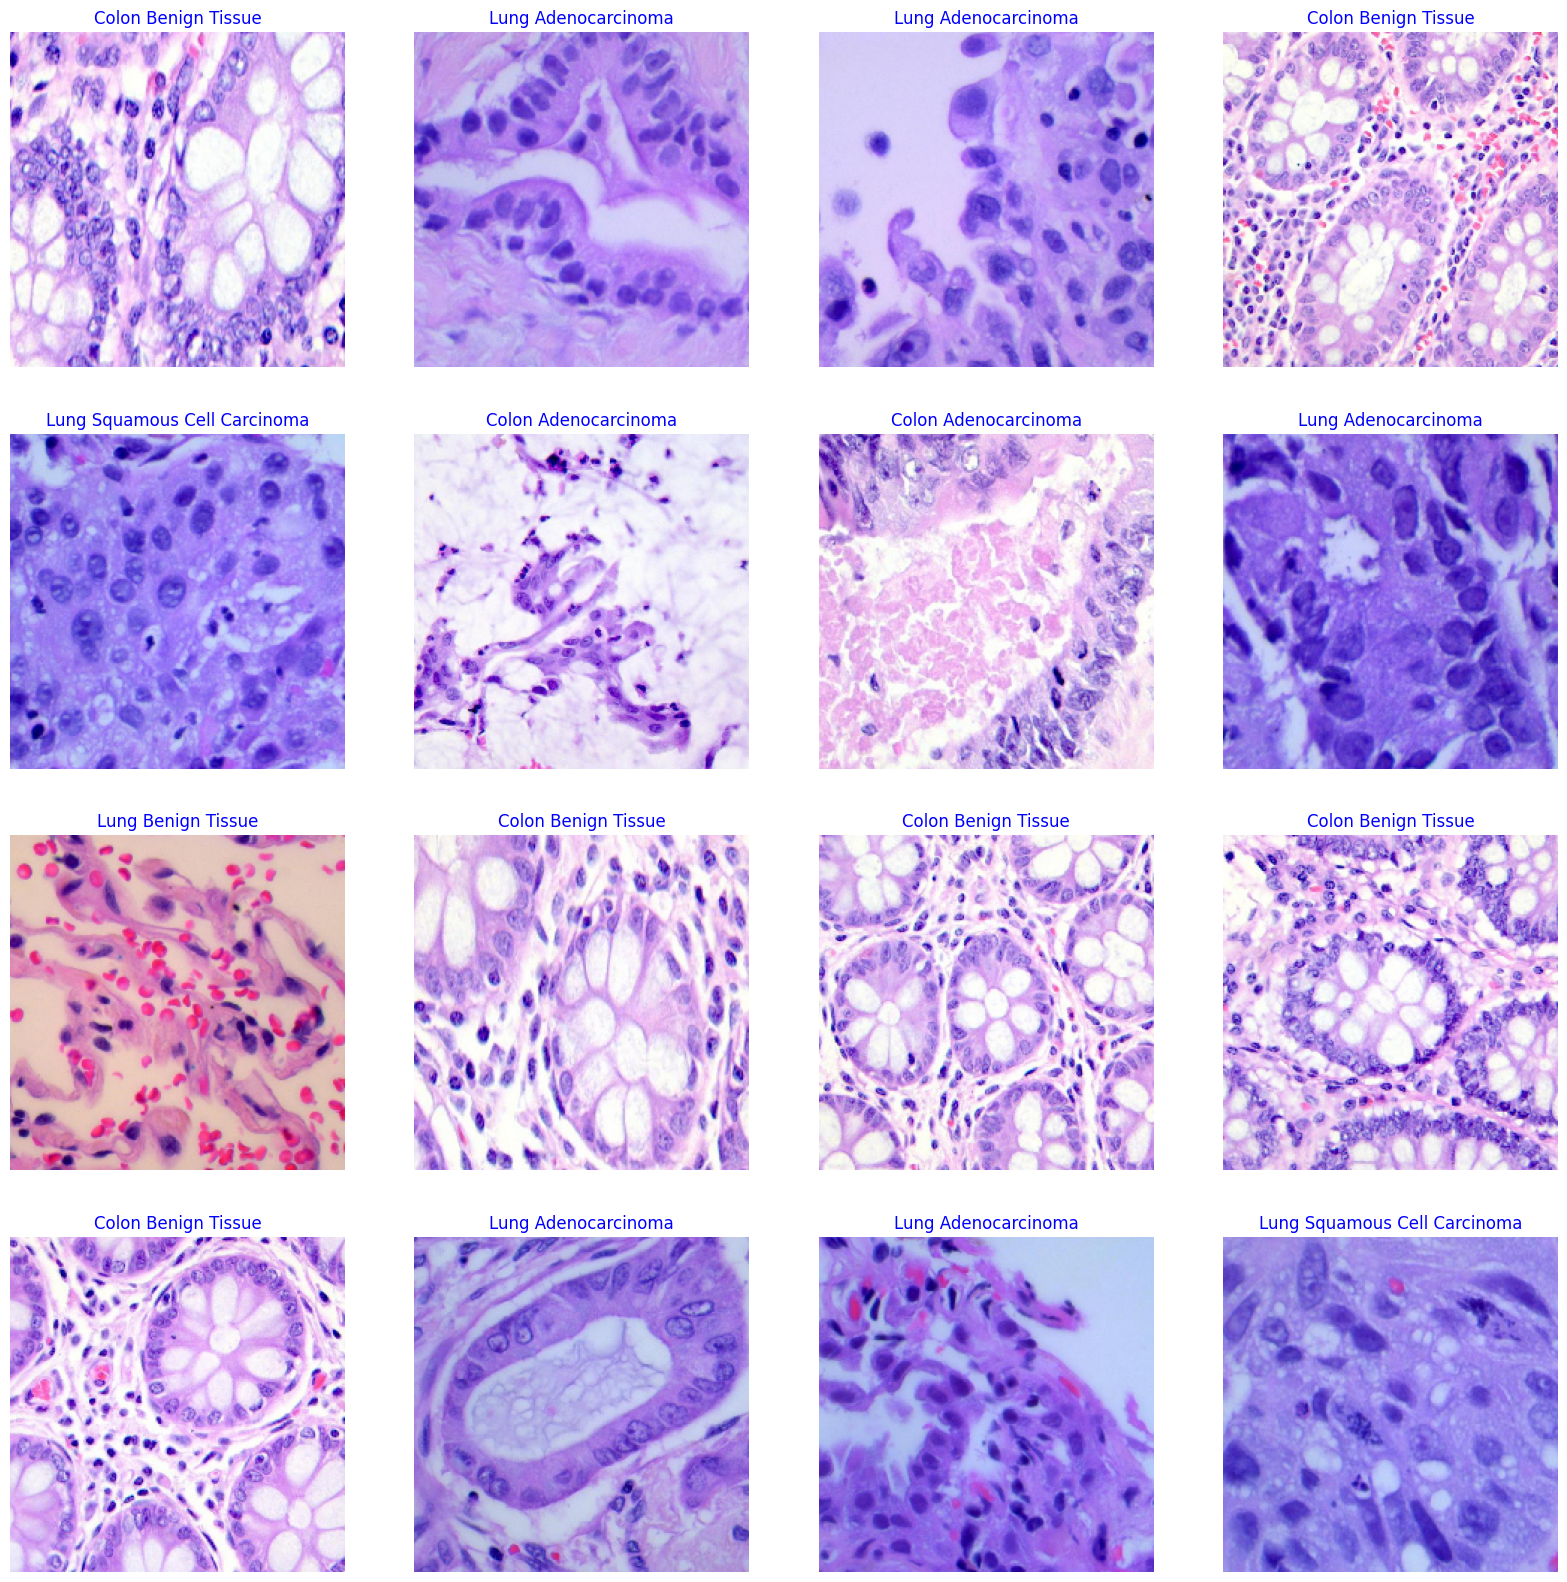

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [22]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape= img_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(class_count, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [23]:
epochs = 10   # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= test_gen,
                    validation_steps= None, shuffle= False)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 879s 119s/step - accuracy: 0.1656 - loss: 57.2595 - val_accuracy: 0.2000 - val_loss: 1.6093
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 843s 119s/step - accuracy: 0.2094 - loss: 1.6105 - val_accuracy: 0.2000 - val_loss: 1.6080
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 856s 118s/step - accuracy: 0.2014 - loss: 1.6075 - val_accuracy: 0.2000 - val_loss: 1.6028
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 837s 118s/step - accuracy: 0.2015 - loss: 1.6031 - val_accuracy: 0.2000 - val_loss: 1.6022
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 840s 118s/step - accuracy: 0.1954 - loss: 1.6029 - val_accuracy: 0.2000 - val_loss: 1.5721
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 838s 118s/step - accuracy: 0.2024 - loss: 1.5588 - val_accuracy: 0.2000 - val_loss: 1.4571
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 840s 118s/step - accuracy: 0.2244 - loss: 1.4884 - val_accuracy: 0.4000 - val_loss: 1.4172
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 862s 118s/step - accuracy: 0.3722 - loss: 1.4083 - val_accuracy: 0.3600 - 

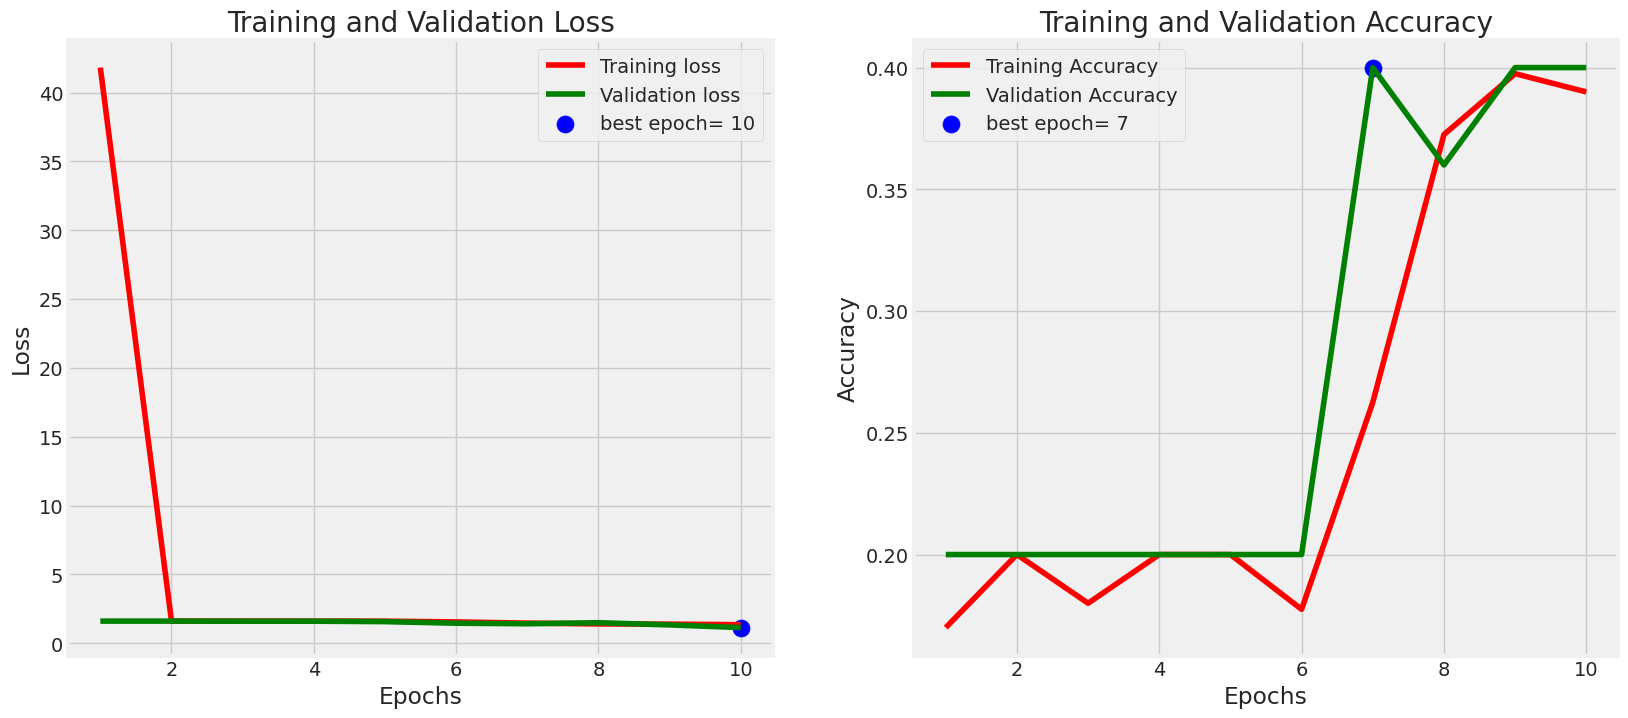

In [24]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


In [25]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

1/1 ━━━━━━━━━━━━━━━━━━━━ 39s 39s/step - accuracy: 0.3750 - loss: 1.2172
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.4000 - loss: 1.1880
1/1 ━━━━━━━━━━━━━━━━━━━━ 30s 30s/step - accuracy: 0.4000 - loss: 1.1392
Train Loss:  1.2172071933746338
Train Accuracy:  0.375
--------------------
Valid Loss:  1.188014268875122
Valid Accuracy:  0.4000000059604645
--------------------
Test Loss:  1.1392232179641724
Test Accuracy:  0.4000000059604645


In [26]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step


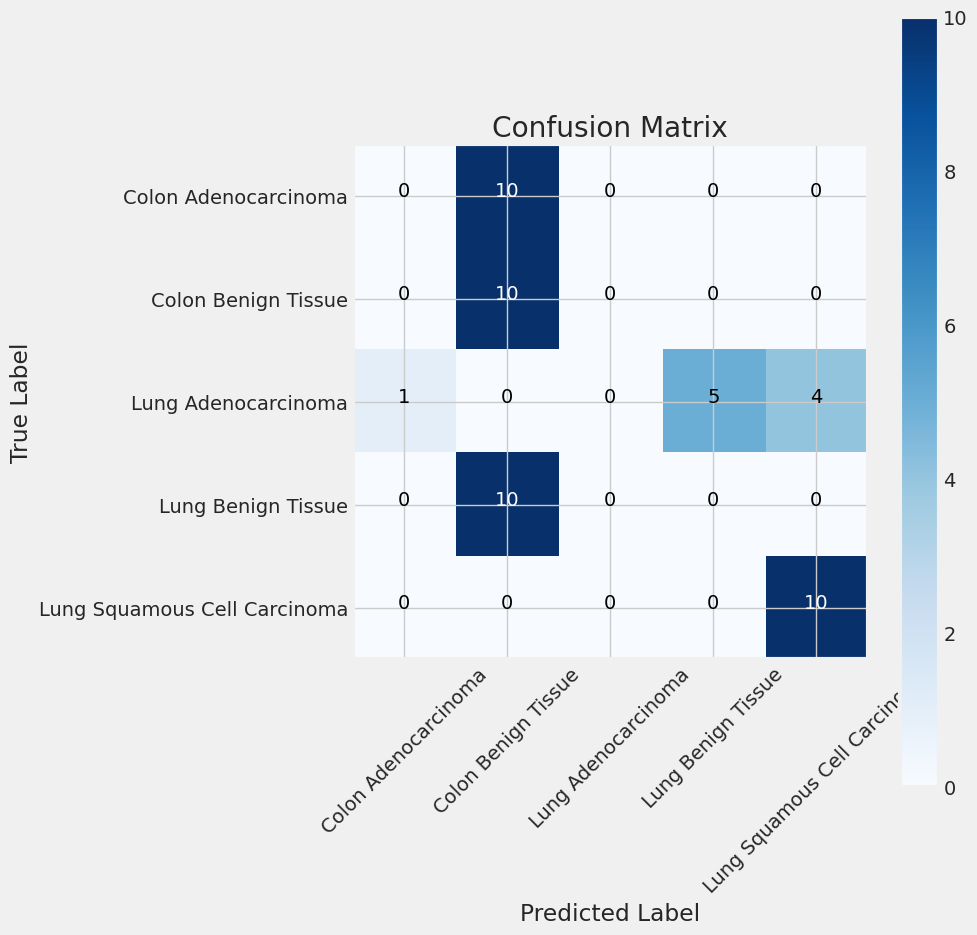

In [27]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


In [28]:
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                              precision    recall  f1-score   support

        Colon Adenocarcinoma       0.00      0.00      0.00        10
         Colon Benign Tissue       0.33      1.00      0.50        10
         Lung Adenocarcinoma       0.00      0.00      0.00        10
          Lung Benign Tissue       0.00      0.00      0.00        10
Lung Squamous Cell Carcinoma       0.71      1.00      0.83        10

                    accuracy                           0.40        50
                   macro avg       0.21      0.40      0.27        50
                weighted avg       0.21      0.40      0.27        50



In [29]:
#Save the model
model.save('Model.h5')

In [30]:
loaded_model = tf.keras.models.load_model('Model.h5', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [33]:
import os

image_path = 'lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg'

# Check if the file exists
if not os.path.exists(image_path):
    # If the file doesn't exist, print an error message and exit
    print(f"Error: Image file not found at {image_path}")
# If the file exists, open it and proceed with prediction
else:
    image = Image.open(image_path)

    # Preprocess the image
    img = image.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    # Make predictions
    predictions = loaded_model.predict(img_array)
    class_labels = classes
    score = tf.nn.softmax(predictions[0])
    print(f"{class_labels[tf.argmax(score)]}")

Error: Image file not found at lung_colon_image_set/lung_image_sets/lung_aca/lungaca1001.jpeg
